<img width="800px" heigh="400px" src="logo.png"></img>

# <!-- AUTHOR --> - AUTHOR : __Dr. Amiehe-Essomba__
# <!-- TITLE --> - TITLE : Sentiment analysis using a Recurent Neural Network (RNN) with (LSTM & GRU)-

## Objectives :
 - The objective is to guess whether airline reviews are **positive, negative or neutral** based on the analysis of the text. 
 - The models used here are based on LSTM and GRU

Original dataset can be find in **[Kaggle](https://www.kaggle.com/datasets/tango911/airline-sentiment-tweets)**  
Note that **Kaggle** offers several easy-to-use [datasets](https://www.kaggle.com/datasets/) for NLP, Computer vision, Pre-trained models


## What we will do here :

 - loading data from and exteranal source (**Kaggle**)
 - Data preprocessing( **cleaning, tokinization, padding**)
 - Building Embedding/LSTM Embedding/GRU models
 - Train and test models
 - Computing metrics for evaluating models
 - Select the best model between LSTM or GRU for this dataset
 - Building the final model 
 - Deploying the best model


In [5]:
#loading numerical modules
%matplotlib inline 
import sys, os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from plotly.subplots import make_subplots as ms 

#loading deep learning modules 
import tensorboard as tb
import tensorflow as tf
from keras.models import Sequential as S 
import plotly.graph_objs as go
import plotly.express as px
from keras.utils import to_categorical as ct
from keras.layers import Dense, LSTM, GRU, Dropout, Embedding, GlobalAveragePooling1D
# splitting data 
from sklearn.model_selection import train_test_split as tts
# module to clear text 
import re


In [6]:
def PATHS(epoch, model_type:str = 'LSTM'):
    log_dir = f'C:\\Users\\amib\\Documents\\DATA\\TWEETS\\logs'
    path_best_model = f"{log_dir}\\"+f"{model_type}-best_model.h5"
    path_models = f"{log_dir}\\" + f"{model_type}"+"-{epoch:04d}-model.h5"

    return log_dir, path_best_model, path_models

In [2]:
def Callbacks(epoch, model_type:str = 'LSTM'):
    log_dir, path_best_model, path_models = PATHS(epoch=epoch, model_type=model_type)

    callbacks_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks_best = tf.keras.callbacks.ModelCheckpoint(filepath=path_best_model, save_best_only=True, 
                                                        verbose=1, monitor='val_accuracy')
    callbacks_models = tf.keras.callbacks.ModelCheckpoint(filepath=path_models, verbose=1)

    return [callbacks_tensorboard, callbacks_best, callbacks_models]

In [25]:
def gru_model(
        x_train : np.ndarray, y_train : np.ndarray, 
        x_test : np.ndarray, y_test : np.ndarray, 
        input_dim : int, output_dim : int, 
        input_length: int, epochs : int =10, label : int = 1
        ):
    callbacks_tensorboard, callbacks_best, callbacks_models = Callbacks(epoch=epochs, model_type='GRU')
    model = S()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(Dropout(rate=0.6))
    model.add(GRU(units=50, activation=tf.keras.activations.tanh, return_sequences=True))
    model.add(GRU(units=128, activation=tf.keras.activations.tanh))
    model.add(Dropout(rate=0.5))
    model.add(Dense(label, activation=tf.keras.activations.sigmoid))
    model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer="rmsprop",
              metrics=["accuracy"])
    
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        validation_data=(x_test, y_test), 
                        batch_size=100, verbose=1,
                        callbacks= [callbacks_tensorboard, callbacks_best, callbacks_models]
                        )
    

    return model, history

In [26]:
def lstm_model(
        x_train : np.ndarray, y_train : np.ndarray, 
        x_test : np.ndarray, y_test : np.ndarray, 
        input_dim : int, output_dim : int, 
        input_length: int, epochs : int =10, label : int = 1
        ):
    
    callbacks_tensorboard, callbacks_best, callbacks_models = Callbacks(epoch=epochs, model_type='LSTM')
    model = S()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(LSTM(units=50, activation=tf.keras.activations.tanh, return_sequences=True))
    model.add(Dropout(rate=0.8))
    model.add(LSTM(units=128, activation=tf.keras.activations.tanh))
    model.add(Dropout(rate=0.5))
    model.add(Dense(label, activation=tf.keras.activations.sigmoid))
    model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer="adam",
              metrics=["accuracy"])
    
    history = model.fit(x_train, y_train, 
                        epochs=epochs, 
                        validation_data=(x_test, y_test), 
                        batch_size=50, verbose=1,
                        callbacks= [callbacks_tensorboard, callbacks_best, callbacks_models]
                        )
    

    return model, history

In [27]:
def get_index(reviews : list, words_index : list, words : list, max_length : int = 100 ):
    reviews_index = []
    history = {"unknown_words" : []}

    size = len(reviews)
    if reviews : 
        for review_word in reviews:
            if type(review_word) == type(str()):
                review_tokens = review_word.split() 
                if review_tokens:
                    unknown         = []
                    review_index    = []

                    for word in review_tokens:
                        word = word.lower().rstrip().lstrip()
                        word = re.sub(r"[^a-zA-Z0-9]", "", word)
                        if word in words:
                            if words_index[ words.index( word ) ] < 10000:
                                review_index.append( words_index[ words.index( word ) ] )
                            else: pass
                        else: unknown.append(word)

                    history["unknown_words"].append(unknown)
                    if len( review_index ) < max_length:
                        review_index = [0 for i in range( max_length - len(review_index ))] + review_index 
                    reviews_index.append(review_index)
                else: pass
            else: break
    else: pass 

    reviews_index = np.array( reviews_index ) 
    return reviews_index, history 

In [11]:
# data location
path = 'C:\\Users\\amib\\Documents\\DATA\\TWEETS\\Tweets.csv'

# loading data 
data =  pd.read_csv(path)

# target names configuration
labels = dict(negative=1, positive=2, neutral=0)
target_names = data.airline_sentiment.values 

# target
target = np.array( [labels[x] for x in target_names]).reshape((-1, ))

# text analysis
text = data.text.values

# input configuration
max_length      = 100   
embedding_dim   = 100
max_words       = 10000

# creating tokens from text 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts=text)

# creating sequences 
sequences = tokenizer.texts_to_sequences(texts=text)

# senquence padding is a form of words normalisation
pad_sequence = tf.keras.preprocessing.sequence.pad_sequences(sequences=sequences, maxlen=max_length, value=0, padding = 'post')

# creating a dataset 
x_train, x_test, y_train, y_test = tts(pad_sequence, target, random_state=1, shuffle=True, test_size=0.2)


In [12]:
# get words index 
words_index  = [index for keys, index in tokenizer.word_index.items() ]
# get words
words        = [keys for keys, index in tokenizer.word_index.items()  ]
# data frame
word_index_df = pd.Series(data = words)

In [17]:
#buiding LSTM model
vocab_size      = x_train.shape[0]

model, history  = lstm_model(
    x_train=x_train, y_train=y_train, 
    x_test=x_test, y_test=y_test,
    input_dim=vocab_size, output_dim=embedding_dim, 
    input_length=max_length
    )

Epoch 1/10
235/235 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.6264
Epoch 1: val_accuracy improved from -inf to 0.62363, saving model to C:\Users\amib\Documents\DATA\TWEETS\logs\LSTM-best_model.h5

Epoch 1: saving model to C:\Users\amib\Documents\DATA\TWEETS\logs\LSTM-0001-model.h5
235/235 [==============================] - 67s 263ms/step - loss: 0.2333 - accuracy: 0.6264 - val_loss: 0.1712 - val_accuracy: 0.6236
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.6277
Epoch 2: val_accuracy did not improve from 0.62363

Epoch 2: saving model to C:\Users\amib\Documents\DATA\TWEETS\logs\LSTM-0002-model.h5
235/235 [==============================] - 62s 263ms/step - loss: 0.2175 - accuracy: 0.6277 - val_loss: 0.1746 - val_accuracy: 0.6236
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.6277
Epoch 3: val_accuracy did not improve from 0.62363

Epoch 3: saving model to C:\Users\amib\D

In [23]:
df_lstm = pd.DataFrame(history.history)
df_lstm.tail(n=5)

,loss,accuracy,val_loss,val_accuracy
5,0.211721,0.627732,0.171645,0.623634
6,0.210342,0.627732,0.171110,0.623634
7,0.210335,0.627732,0.171735,0.623634
8,0.213392,0.627732,0.172774,0.623634
9,0.210119,0.627732,0.171080,0.623634


In [ ]:
#buiding LSTM model
model_gru, history_gru  = gru_model(
    x_train=x_train, y_train=y_train, 
    x_test=x_test, y_test=y_test,
    input_dim=vocab_size, output_dim=embedding_dim, 
    input_length=max_length
    )

In [ ]:
df_gru = pd.DataFrame(history_gru.history)
df_gru.tail(n=5)

* both model give the same loss and score values 

Then for the next we'll keep working with the __LSTM__ model instead __GRU__

In [29]:
# model type
model_type      = 'LSTM'
_path_          = log_dir = f'C:\\Users\\amib\\Documents\\DATA\\TWEETS\\logs'
#location where the best model is located
path            = f"{log_dir}\\"+f"{model_type}-best_model.h5"
#loading the best model
model           = tf.keras.models.load_model(filepath=path)
# evaluting model 
loss, score    = model.evaluate(x_test, y_test)

92/92 [==============================] - 8s 78ms/step - loss: 0.1712 - accuracy: 0.6236


In [30]:
print(f"score : {score}\nloss : {loss}")

score : 0.623633861541748
loss : 0.1711570918560028


In [31]:
# examples of Air France reviews 
r1= """
    Mabuhay Lounge is really trying to offer a nice selection of food items. 
    The people that work in the Lounge are awesome! The lounge is very clean including the restroom. 
    Its a little congested at times, but other than that I think it's a nice place to relax before a flight.
    Thank you, Mabuhay Lounge!
    """
r2= """
    PAGGS Lounge (beside Gate no. 7) - PAL Frequent Flyer Mabuhay Miles - Elite Level. My first time on this lounge. 
    I used to go to the paid lounge at this Terminal at the other end. Plenty of food choices, overflowing coffee 
    Nespresso (I think), alcoholic beverages. The gentleman at the bar was so accommodating, once when the lounge 
    was full he got a bar stool and asked mo sit in front of the bar. 
    I lounged there for three hours. Toilet was clean and smelling fresh. Wifi is available, 
    just ask the password from any of the staff.
    """

r3= """
    Poor food and beverage selection at the Mabuhay Miles Lounge. Not a service expected from a 4 star airline. PAL must upgrade this 
    lounge in order to be at par with the services offered by other airlines.
    """

r4= """
    An improvement compared to a couple of years ago. Still small compared to other 
    lounges but could not complain as the food choices were good. Wifi was great. Service was impeccable. 
    If there's one thing I can complain, that is the pretty noisy announcements made when it's 
    time for boarding or when a flight is delayed. Overall, a good lounge.
    """

reviews = [r1, r2, r3, r4]

info, unknow_words = get_index(reviews = reviews, words_index = words_index, words = words )
print(f"words_index :\n{info}\nunknow_words :\n{unknow_words}")

words_index :
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0  870   14  136  116    1  509    4  289
  3071   18  449 1502    2  145   27  177   15    2  870   38  301    2
   870   14  155 1559 1914    2 4413  293    4  503   28  232   31  197
   166   27    3  251  293    4  289  691    1 4410  194    4    8   71
     6  870]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
   870   82   26  328 1038  963  242 1554 1345   11  154   51    9   29
   870    3  536    1  133    1    2  378  870   28   29  554   28    2
   197  603 1351   18  449 3742 1266    3  251 6101    2 4708   28    2
  2606   23   47 2774  493   63    2  870   23  393  275   94    4 2606
    10  513  481   15  825   18    2 2606    3   73    7  489   60 3078
    23 1559   10 2490  311   14  329 

In [32]:
# reviews predictions

reviews_index = info.reshape((-1, 100))
confidence_score = []
predictions = []



predicts =  model.predict(reviews_index) 
for p in predicts:
    if p[0] > 0.5 : predictions.append( {"predicted" : "positive review", "score" : p[0]} )
    elif p[0] == 0.5 : predictions.append( {"predicted" : "neutral review", "score" : p[0]} )
    else: predictions.append( {"predicted" : "negative review", "score" : p[0]} )



1/1 [==============================] - 1s 922ms/step


In [33]:
predictions

[{'predited': 'positive review', 'score': 0.9493405},
 {'predited': 'positive review', 'score': 0.9490003},
 {'predited': 'positive review', 'score': 0.94966143},
 {'predited': 'positive review', 'score': 0.94919974}]

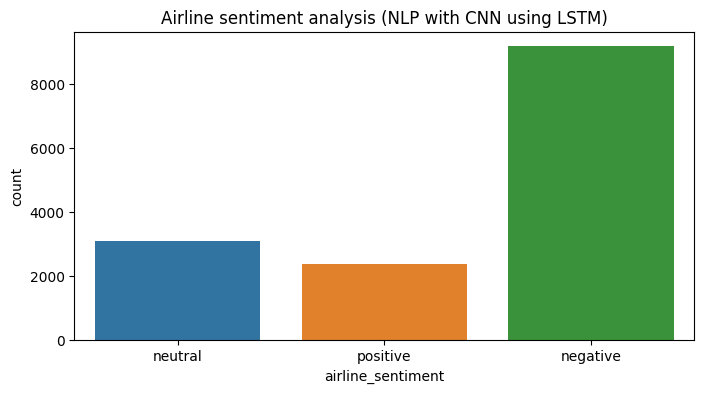

In [34]:
# plot section
fig, ax = plt.subplots(1,1, figsize=(8, 4))
sns.countplot(data, x='airline_sentiment', ax=ax)
ax.set_title("Airline sentiment analysis (NLP with CNN using LSTM)")
plt.show()